In [1]:
# Pregnancy Risk Calculator Model Training Notebook (with Ridge Logistic Regression)

import pandas as pd
import numpy as np
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression


In [2]:
# Updated: Calculator 1:
# Predictors: Maternal Age, NtMoM, NIPT results
# Outcomes: Composite, Structural, ChromProbs, Livebirth, SAB, (+ "T21", "T18", "T13", "Turners", "OtherChroms") --> The additional part
# Load dataset
data = pd.read_csv("CH_Dataset_0623.csv")

# Drop irrelevant columns
drop_cols = ['Record ID', "Ethnicity", "NonAsian", "AnomalyType", "AnomalyDescribe", "AnomalyDescribe2",
             "ChromsProb_Other", "SABGA_w", "SABGA_d", "IAB", "IABGA_w", "IABGA_D",'CRL',
             "Dmode", "GeneticAndAnomaly", 'PosNIPTtype',
             'UnreportableNIPT', 'VISTARA_posneg', 'VISTARA_type', 'DxtestingGA-w', 'DxtestingGA-d', 'FFSGA_w',
             'FFSGA_d', 'FFS_Nfsize', 'NTGA-w', 'NTGA-d', 'NT', 'NTExpect', 'CRLrounded',
             'FFS_Chchange (0=No comment, 1= CH smaller, 2=CH resolved, 3=CH bigger, 4=CH same)',
             'OtherUS_Chchange (0=No comment, 1= CH smaller, 2=CH resolved, 3=CH bigger, 4=CH same)', 'Gcvisit_YN', 
            'AvailGenInfo','Gctests', 'Dxtesting', 'FFS_YN','AneuploidyType','White','Black', 'Asian', 'MiddleEastern', 'Latin', 'Native', 'Other']
data.drop(columns=drop_cols, errors='ignore', inplace=True)

data.rename(columns={'NIPT results (Neg = 0, Pos=1, Not report=2)': 'NIPT_results'}, inplace=True)

# Define continuous and categorical variables
continuous_vars = ['Age', 'NtMoM']
categorical_vars = ['NIPT_results']

# Removed so no longer relevant
# Handle ResolvedCH missing as 'Not Reported' (set as 2 for modeling)
#data['ResolvedCH'] = data['ResolvedCH'].replace({np.nan: 2})

# View missing summary
missing_summary = (
    data.isnull()
    .mean()
    .reset_index()
    .rename(columns={'index': 'Variable', 0: 'MissingProportion'})
    .sort_values(by='MissingProportion', ascending=False)
)
print(missing_summary)


        Variable  MissingProportion
0            Age           0.039216
1          NtMoM           0.039216
2   NIPT_results           0.039216
3     ResolvedCH           0.039216
4        Anomaly           0.039216
5     ChromsProb           0.039216
6            SAB           0.039216
7      Livebirth           0.039216
8      Composite           0.039216
9            T21           0.039216
10           T18           0.039216
11           T13           0.039216
12       Turners           0.039216
13   OtherChroms           0.039216


In [3]:
# Define continuous and categorical variables
continuous_vars = ['Age', 'NtMoM']
categorical_vars = ['NIPT_results']
target_vars = ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]

# Drop rows with missing or '.' in target variables
initial_rows = data.shape[0]
data = data[~data[target_vars].isnull().any(axis=1)]
data = data[~(data[target_vars] == ".").any(axis=1)]
print(f"\nDropped rows with missing or '.' in targets: {initial_rows - data.shape[0]}")

# Convert 'NIPT_results' to numeric and fill problematic values with 2
data['NIPT_results'] = pd.to_numeric(data['NIPT_results'], errors='coerce').fillna(2).astype(int)

# Convert all continuous vars to numeric, coerce bad entries (like '.')
for col in continuous_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Print value counts of targets
print("\nTarget variable value counts after cleaning:")
for target in target_vars:
    if target in data.columns:
        print(f"{target}:\n{data[target].value_counts(dropna=False)}")

# Print predictor row counts before/after drop for each target
for target in target_vars:
    if target not in data.columns:
        continue

    df_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    df_target[target] = pd.to_numeric(df_target[target], errors='coerce').astype(int)

    before_drop = df_target.shape[0]
    df_target = df_target.dropna(subset=continuous_vars + categorical_vars)
    after_drop = df_target.shape[0]

    print(f"\nTarget: {target}")
    print(f"Rows before dropping invalid predictors: {before_drop}")
    print(f"Rows after dropping invalid predictors:  {after_drop}")
 


Dropped rows with missing or '.' in targets: 42

Target variable value counts after cleaning:
Composite:
Composite
1.0    213
0.0     51
Name: count, dtype: int64
Anomaly:
Anomaly
0    203
1     61
Name: count, dtype: int64
ChromsProb:
ChromsProb
1    177
0     87
Name: count, dtype: int64
SAB:
SAB
0    220
1     44
Name: count, dtype: int64
Livebirth:
Livebirth
0    196
1     68
Name: count, dtype: int64
T21:
T21
0.0    191
1.0     73
Name: count, dtype: int64
T18:
T18
0.0    225
1.0     39
Name: count, dtype: int64
T13:
T13
0.0    250
1.0     14
Name: count, dtype: int64
Turners:
Turners
0.0    241
1.0     23
Name: count, dtype: int64
OtherChroms:
OtherChroms
0.0    236
1.0     28
Name: count, dtype: int64

Target: Composite
Rows before dropping invalid predictors: 264
Rows after dropping invalid predictors:  251

Target: Anomaly
Rows before dropping invalid predictors: 264
Rows after dropping invalid predictors:  251

Target: ChromsProb
Rows before dropping invalid predictors: 264


In [4]:
for col in continuous_vars:
    bad_vals = data[col][~data[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()]
    if not bad_vals.empty:
        print(f"Bad values in {col}: {bad_vals.unique()}")

Bad values in NtMoM: [nan]


In [5]:
import sklearn
print(sklearn.__version__)

1.3.0


In [6]:
print(data[continuous_vars + categorical_vars].isnull().sum())

Age              0
NtMoM           13
NIPT_results     0
dtype: int64


In [7]:
# Clean, continuation cell to append to your current notebook
# Evaluates all models across all targets with SHAP interpretability for Ridge Logistic Regression

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import IterativeImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define models
models = {
    'Lasso_Logistic_Regression': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=1.0, random_state=42),
    'Ridge_Logistic_Regression': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=1.0, random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive_Bayes': BernoulliNB(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=300, random_state=42)
}

# Define metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

target_vars = ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]
all_results = {}

for target in target_vars:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    print(f"\n==== Evaluating for target: {target} ====")
    
    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)

    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    # Impute only for continuous (NtMoM)
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        print(f"Evaluating {name} for {target}...")
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        try:
            scores = cross_validate(pipeline, X, y, cv=cv, scoring=scorers, n_jobs=-1)
            results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scorers}
        except Exception as e:
            print(f"Error wit sh {name} on {target}: {e}")

    metrics_df = pd.DataFrame(results).T
    all_results[target] = metrics_df
    metrics_df.to_csv(f"{target}_model_evaluation_results.csv")
    print(f"\nResults for {target}:\n{metrics_df}")



/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



==== Evaluating for target: Composite ====
Evaluating Lasso_Logistic_Regression for Composite...
Evaluating Ridge_Logistic_Regression for Composite...
Evaluating Random_Forest for Composite...
Evaluating SVM_RBF for Composite...
Evaluating SVM_Linear for Composite...
Evaluating XGBoost for Composite...
Evaluating Naive_Bayes for Composite...
Evaluating KNN for Composite...
Evaluating MLP for Composite...

Results for Composite:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.723730   0.934921  0.709302  0.805269  0.402729   
Ridge_Logistic_Regression  0.723730   0.934921  0.709302  0.805269  0.402729   
Random_Forest              0.731132   0.871152  0.788704  0.825772  0.242818   
SVM_RBF                    0.696880   0.925658  0.681063  0.781956  0.364072   
SVM_Linear                 0.697170   0.939696  0.676744  0.781198  0.376682   
XGBoost                    0.723440   0.843710  0.807420  0.824584  0.171288   
Naive_B

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating SVM_RBF for Anomaly...
Evaluating SVM_Linear for Anomaly...
Evaluating XGBoost for Anomaly...
Evaluating Naive_Bayes for Anomaly...
Evaluating KNN for Anomaly...
Evaluating MLP for Anomaly...

Results for Anomaly:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.564514   0.262562  0.493590  0.338869  0.068713   
Ridge_Logistic_Regression  0.564514   0.261754  0.493590  0.338905  0.068134   
Random_Forest              0.640203   0.247395  0.278205  0.259358  0.025410   
SVM_RBF                    0.564659   0.202494  0.308974  0.241207 -0.045761   
SVM_Linear                 0.507692   0.247368  0.557692  0.333462  0.044894   
XGBoost                    0.666836   0.285476  0.342308  0.303421  0.093841   
Naive_Bayes                0.541872   0.267425  0.542308  0.354185  0.074344   
KNN                        0.556749   0.210066  0.343590  0.260188 -0.033132   
MLP                        0.575907   0.234203  0.37820

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating SVM_RBF for ChromsProb...
Evaluating SVM_Linear for ChromsProb...
Evaluating XGBoost for ChromsProb...
Evaluating Naive_Bayes for ChromsProb...
Evaluating KNN for ChromsProb...
Evaluating MLP for ChromsProb...


/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv


Results for ChromsProb:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.727286   0.848333  0.729048  0.781554  0.436221   
Ridge_Logistic_Regression  0.731132   0.849252  0.734762  0.785304  0.442125   
Random_Forest              0.727286   0.816003  0.768889  0.788698  0.413127   
SVM_RBF                    0.738679   0.863147  0.729048  0.789531  0.462924   
SVM_Linear                 0.727576   0.837883  0.763968  0.775704  0.450521   
XGBoost                    0.719594   0.809929  0.763175  0.783107  0.392846   
Naive_Bayes                0.742743   0.852546  0.758413  0.791547  0.468867   
KNN                        0.693179   0.822783  0.695238  0.750087  0.372009   
MLP                        0.715965   0.838101  0.717937  0.770899  0.414988   

                            roc_auc  
Lasso_Logistic_Regression  0.855453  
Ridge_Logistic_Regression  0.855145  
Random_Forest              0.800817  
SVM_RBF               

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating Random_Forest for Livebirth...
Evaluating SVM_RBF for Livebirth...
Evaluating SVM_Linear for Livebirth...
Evaluating XGBoost for Livebirth...
Evaluating Naive_Bayes for Livebirth...
Evaluating KNN for Livebirth...
Evaluating MLP for Livebirth...

Results for Livebirth:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.734761   0.508929  0.573626  0.512534  0.357814   
Ridge_Logistic_Regression  0.730987   0.491071  0.573626  0.508205  0.347178   
Random_Forest              0.776415   0.570455  0.632967  0.594635  0.447129   
SVM_RBF                    0.753628   0.540357  0.604396  0.549080  0.400874   
SVM_Linear                 0.802903   0.630549  0.542857  0.573109  0.456527   
XGBoost                    0.765094   0.544920  0.589011  0.560500  0.406290   
Naive_Bayes                0.787808   0.599672  0.542857  0.554718  0.429556   
KNN                        0.696880   0.452520  0.618681  0.514372  0.319580   

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating SVM_RBF for T21...
Evaluating SVM_Linear for T21...
Evaluating XGBoost for T21...
Evaluating Naive_Bayes for T21...
Evaluating KNN for T21...
Evaluating MLP for T21...

Results for T21:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.655660   0.437578  0.669524  0.518840  0.297703   
Ridge_Logistic_Regression  0.651814   0.429886  0.669524  0.515137  0.290773   
Random_Forest              0.659144   0.394906  0.451429  0.419237  0.181954   
SVM_RBF                    0.655588   0.422053  0.573333  0.481431  0.243627   
SVM_Linear                 0.712337   0.498504  0.559048  0.517944  0.323441   
XGBoost                    0.640203   0.373149  0.437143  0.401732  0.148528   
Naive_Bayes                0.685922   0.476599  0.601905  0.516630  0.310366   
KNN                        0.632511   0.389111  0.574286  0.461445  0.208995   
MLP                        0.640421   0.395802  0.574286  0.467384  0.219107   

  

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating Ridge_Logistic_Regression for T18...
Evaluating Random_Forest for T18...
Evaluating SVM_RBF for T18...
Evaluating SVM_Linear for T18...
Evaluating XGBoost for T18...
Evaluating Naive_Bayes for T18...
Evaluating KNN for T18...
Evaluating MLP for T18...

Results for T18:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.693541   0.278415  0.646429  0.383863  0.262883   
Ridge_Logistic_Regression  0.693541   0.278415  0.646429  0.383863  0.262883   
Random_Forest              0.704790   0.201648  0.339286  0.252554  0.087635   
SVM_RBF                    0.651669   0.234146  0.564286  0.325199  0.176106   
SVM_Linear                 0.720029   0.300461  0.646429  0.405273  0.291421   
XGBoost                    0.697460   0.181154  0.260714  0.211925  0.035983   
Naive_Bayes                0.720029   0.300461  0.646429  0.405273  0.291421   
KNN                        0.621263   0.181667  0.464286  0.259449  0.080941   

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating Random_Forest for T13...
Evaluating SVM_RBF for T13...
Evaluating SVM_Linear for T13...
Evaluating XGBoost for T13...
Evaluating Naive_Bayes for T13...
Evaluating KNN for T13...
Evaluating MLP for T13...

Results for T13:
                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.613570   0.058951  0.400000  0.101978  0.017494   
Ridge_Logistic_Regression  0.624964   0.060062  0.400000  0.103634  0.022540   
Random_Forest              0.867489   0.113016  0.266667  0.156667  0.108461   
SVM_RBF                    0.750145   0.082531  0.400000  0.135511  0.085550   
SVM_Linear                 0.598621   0.061972  0.466667  0.108431  0.037533   
XGBoost                    0.867489   0.103571  0.200000  0.133506  0.076360   
Naive_Bayes                0.659797   0.065791  0.466667  0.114336  0.060720   
KNN                        0.757910   0.060556  0.266667  0.096681  0.024745   
MLP                        0.780479   0.087138 

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

Evaluating Random_Forest for Turners...
Evaluating SVM_RBF for Turners...
Evaluating SVM_Linear for Turners...
Evaluating XGBoost for Turners...
Evaluating Naive_Bayes for Turners...
Evaluating KNN for Turners...
Evaluating MLP for Turners...


/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv


Results for Turners:
                           accuracy  precision  recall        f1       mcc  \
Lasso_Logistic_Regression  0.829390   0.313333    0.79  0.444754  0.423772   
Ridge_Logistic_Regression  0.829390   0.312727    0.79  0.444042  0.423284   
Random_Forest              0.863861   0.306061    0.43  0.342857  0.284682   
SVM_RBF                    0.833382   0.285824    0.61  0.384585  0.335718   
SVM_Linear                 0.833237   0.313203    0.75  0.437499  0.409295   
XGBoost                    0.860015   0.261538    0.38  0.288889  0.234179   
Naive_Bayes                0.727141   0.219805    0.83  0.345750  0.328782   
KNN                        0.829753   0.232821    0.43  0.283810  0.223793   
MLP                        0.833527   0.259921    0.52  0.342892  0.283002   

                            roc_auc  
Lasso_Logistic_Regression  0.877823  
Ridge_Logistic_Regression  0.874490  
Random_Forest              0.772474  
SVM_RBF                    0.802360  
SVM_Lin

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

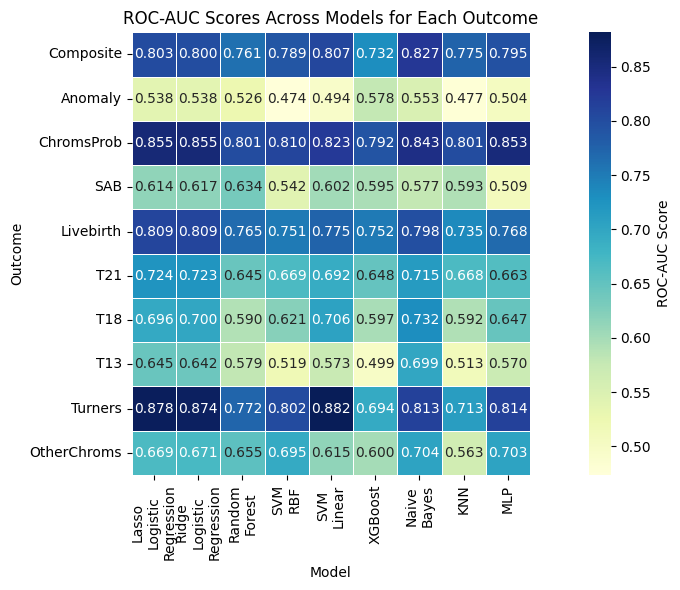

Heatmap saved as roc_auc_heatmap.png


In [8]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you have all_results dictionary containing ROC-AUC for each outcome
# For clarity:
# all_results = {
#     'Composite': metrics_df,
#     'Anomaly': metrics_df,
#     ...
# }

# Collect ROC-AUC scores into a DataFrame
roc_auc_df = pd.DataFrame({
    target: all_results[target]['roc_auc']
    for target in all_results.keys()
}).T  # Transpose to have outcomes as rows

# Optional: clean model names for plot readability
roc_auc_df.columns = [col.replace('_', '\n') for col in roc_auc_df.columns]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    roc_auc_df,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'ROC-AUC Score'},
    linewidths=0.5,
    square=True
)
plt.title("ROC-AUC Scores Across Models for Each Outcome")
plt.ylabel("Outcome")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("roc_auc_heatmap.png", dpi=300)
plt.show()

print("Heatmap saved as roc_auc_heatmap.png")


In [9]:
!pip install matplotlib
! pip install shap
import matplotlib
print(matplotlib.__version__)

3.10.3



==== Coefficient and SHAP Analysis (LASSO) for Composite ====


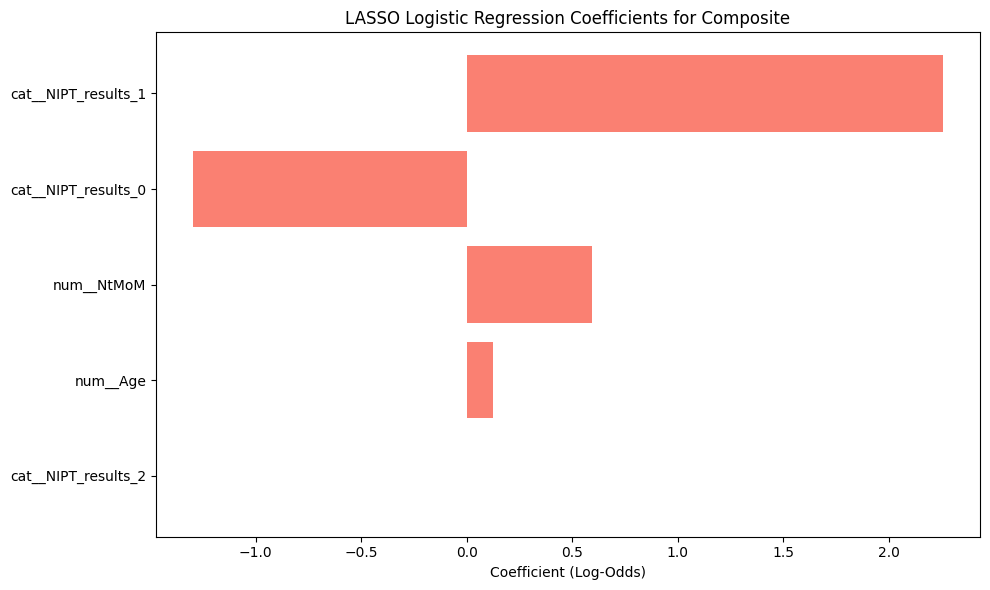

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.126658
1           num__NtMoM     0.595628
2  cat__NIPT_results_0    -1.295003
3  cat__NIPT_results_1     2.255351


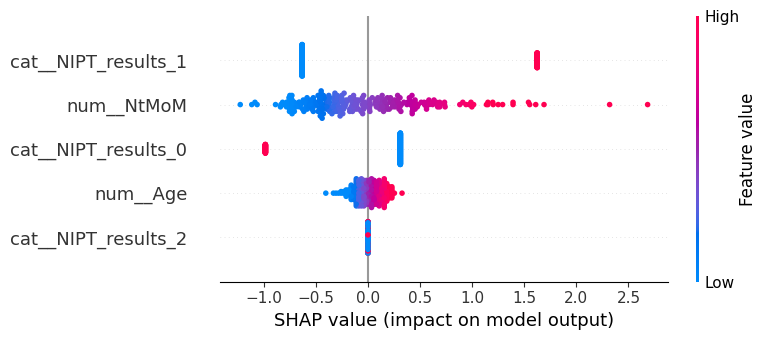


==== Coefficient and SHAP Analysis (LASSO) for Anomaly ====


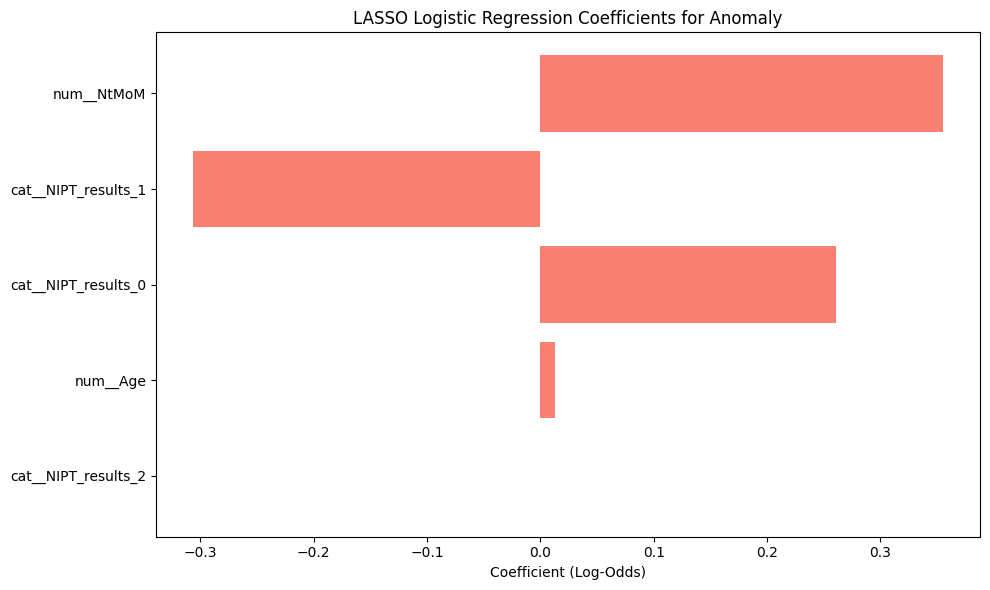

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.013073
2  cat__NIPT_results_0     0.261177
3  cat__NIPT_results_1    -0.306100
1           num__NtMoM     0.354760


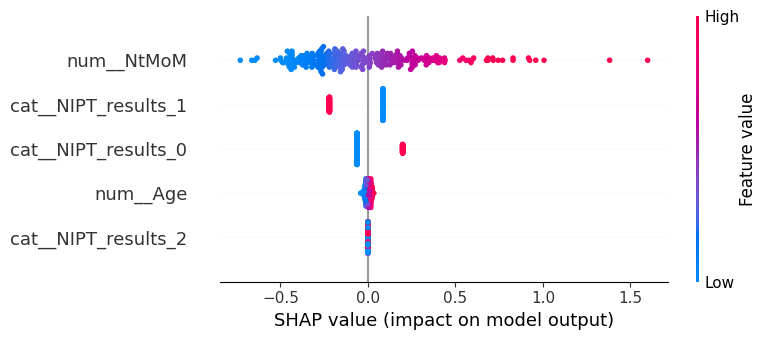


==== Coefficient and SHAP Analysis (LASSO) for ChromsProb ====


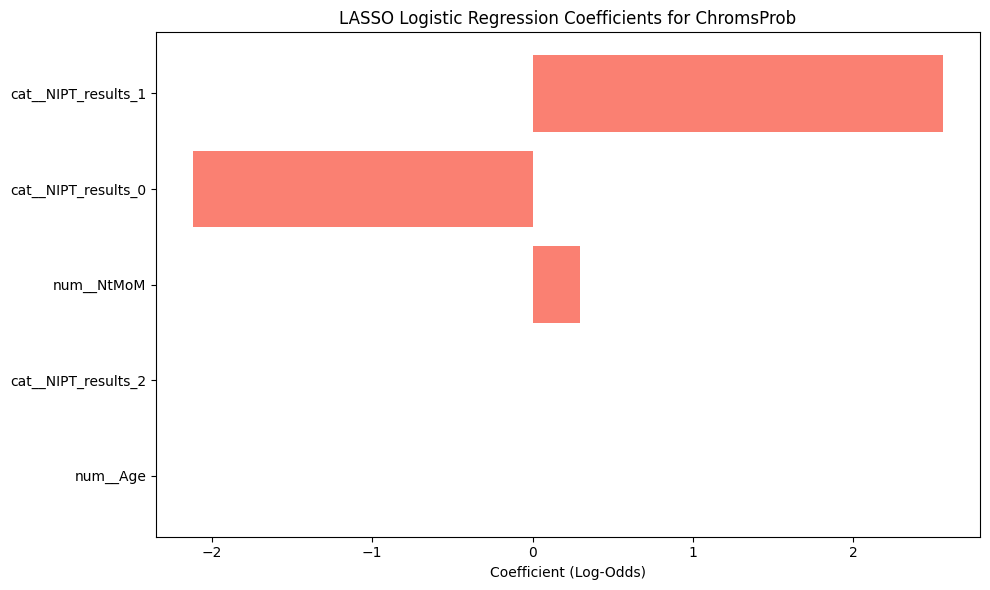

               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1           num__NtMoM     0.298326
2  cat__NIPT_results_0    -2.113538
3  cat__NIPT_results_1     2.555031


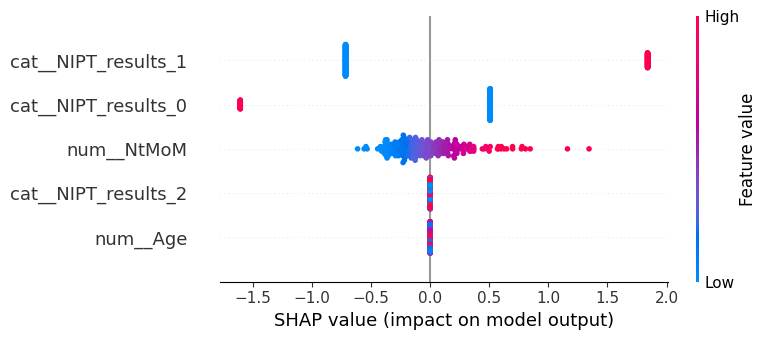


==== Coefficient and SHAP Analysis (LASSO) for SAB ====


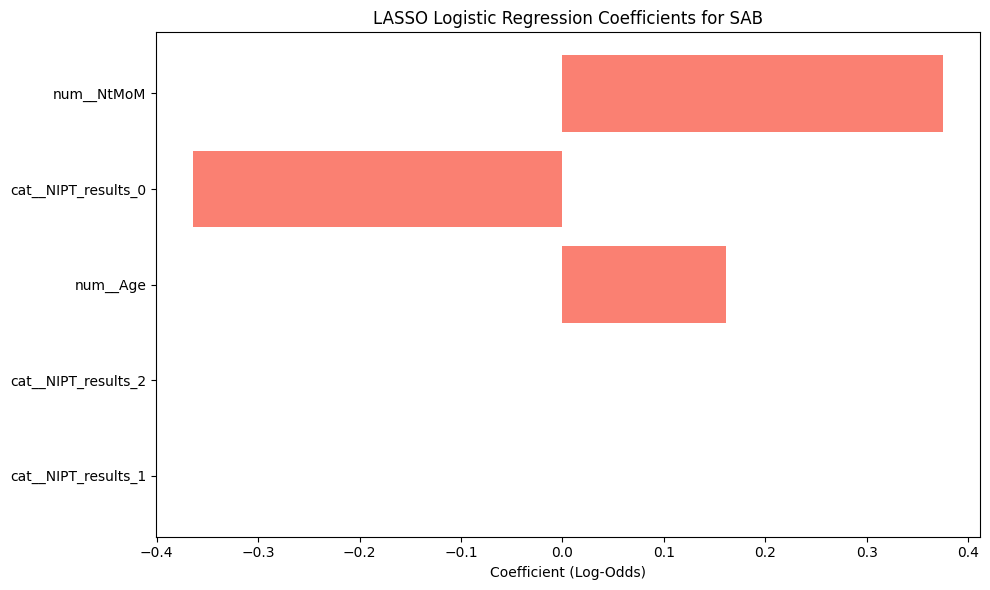

               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age     0.161199
2  cat__NIPT_results_0    -0.363773
1           num__NtMoM     0.374793


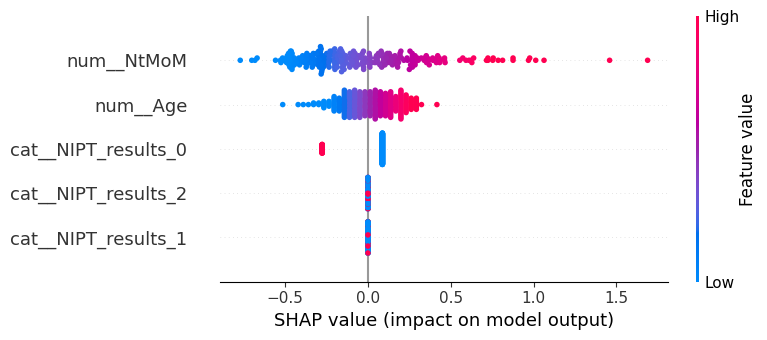


==== Coefficient and SHAP Analysis (LASSO) for Livebirth ====


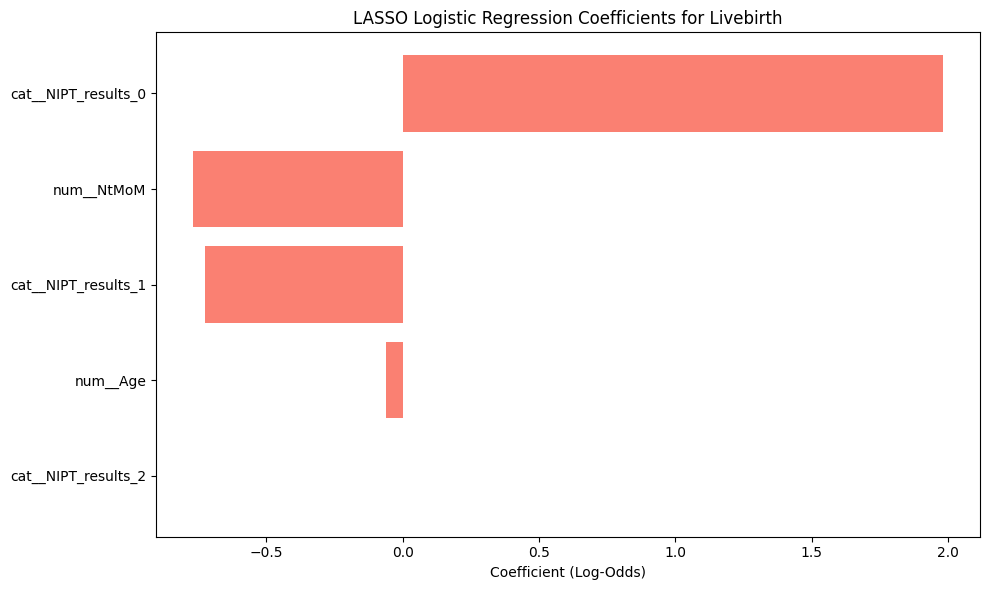

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.062487
3  cat__NIPT_results_1    -0.725343
1           num__NtMoM    -0.767927
2  cat__NIPT_results_0     1.980755


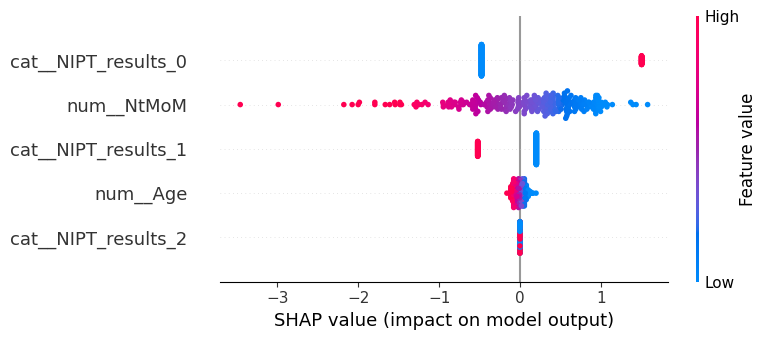


==== Coefficient and SHAP Analysis (LASSO) for T21 ====


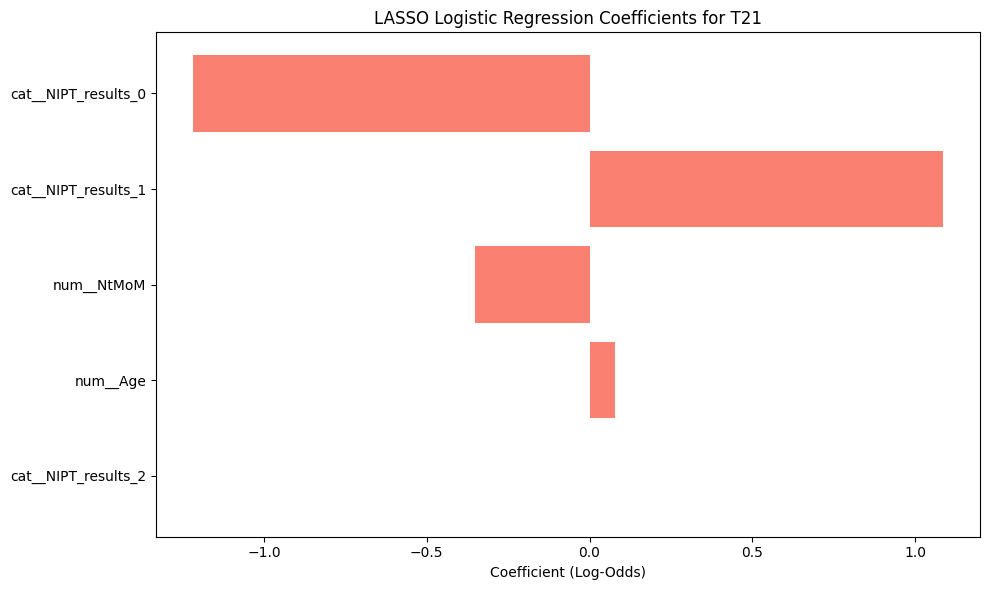

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.078011
1           num__NtMoM    -0.351624
3  cat__NIPT_results_1     1.084048
2  cat__NIPT_results_0    -1.216568


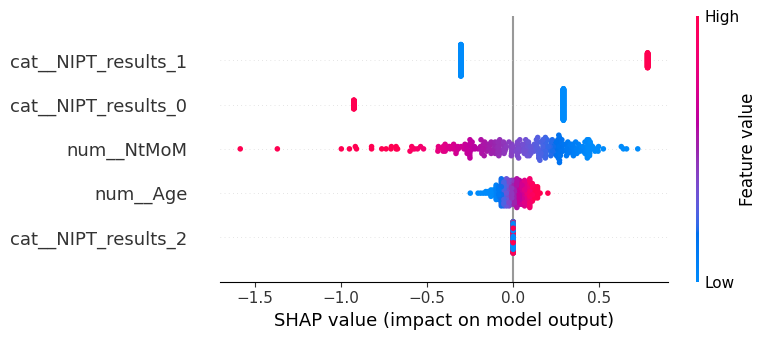


==== Coefficient and SHAP Analysis (LASSO) for T18 ====


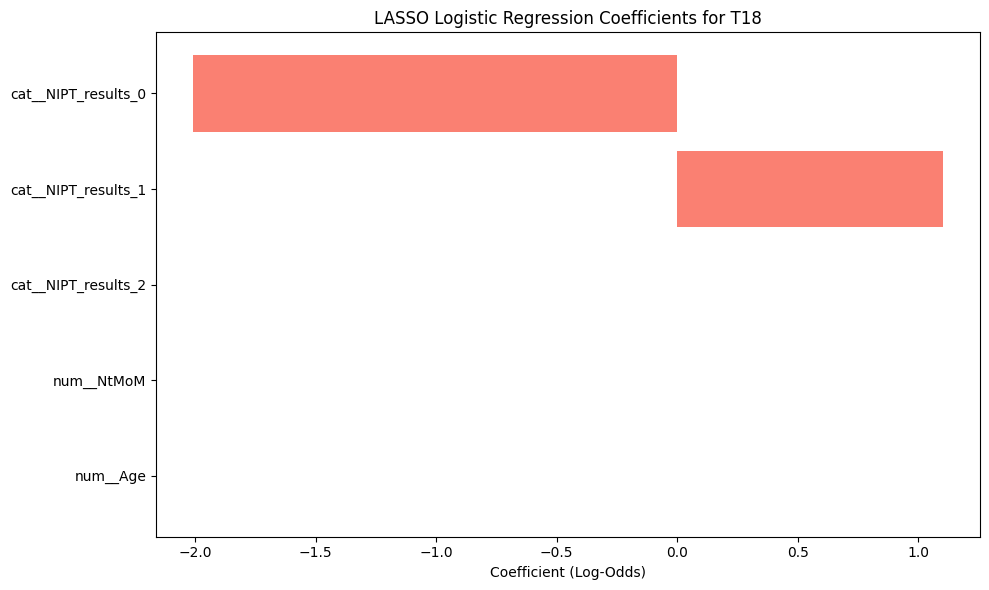

               Feature  Coefficient
0             num__Age     0.000000
1           num__NtMoM     0.000000
4  cat__NIPT_results_2     0.000000
3  cat__NIPT_results_1     1.101183
2  cat__NIPT_results_0    -2.006748


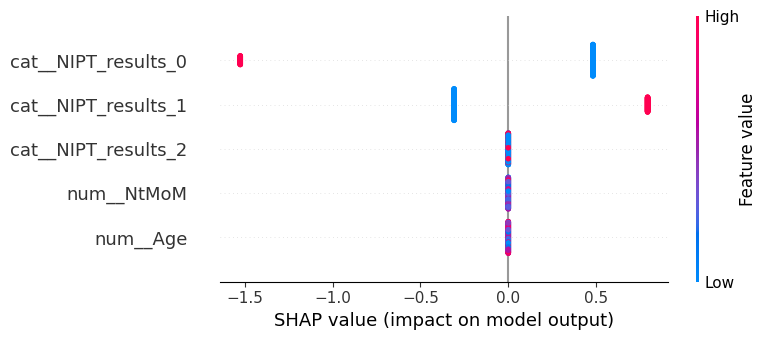


==== Coefficient and SHAP Analysis (LASSO) for T13 ====


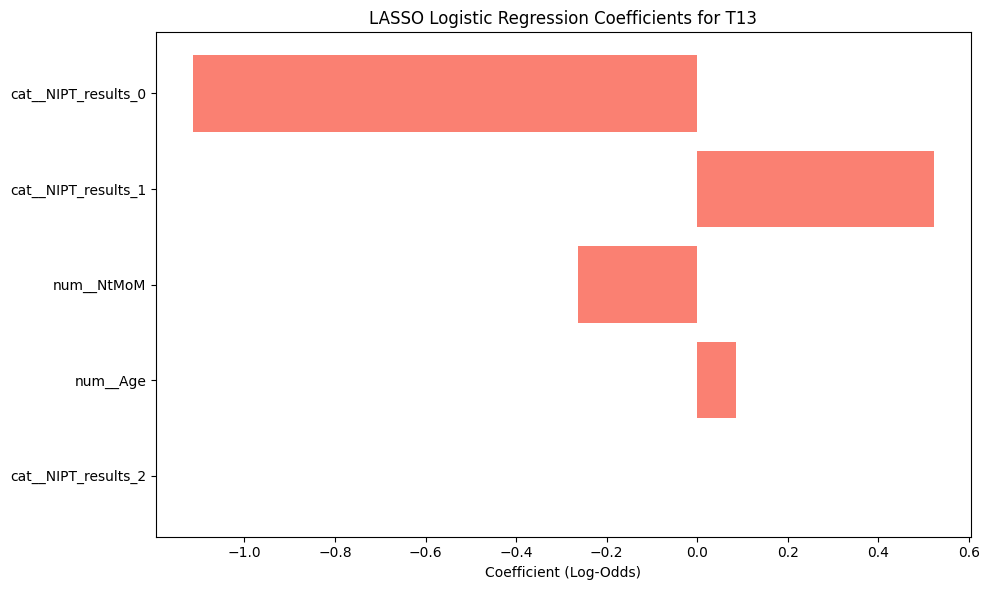

               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.085971
1           num__NtMoM    -0.262341
3  cat__NIPT_results_1     0.522712
2  cat__NIPT_results_0    -1.113505


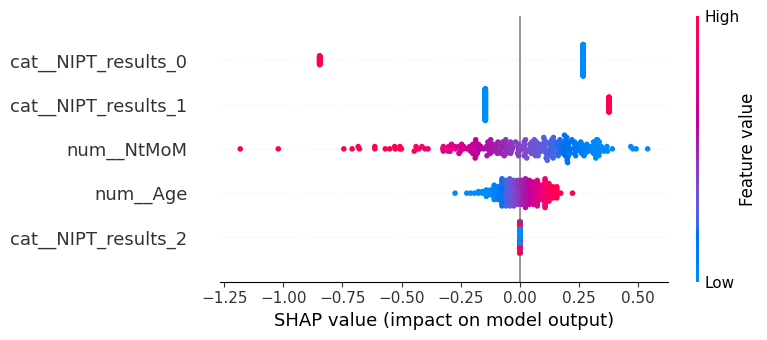


==== Coefficient and SHAP Analysis (LASSO) for Turners ====


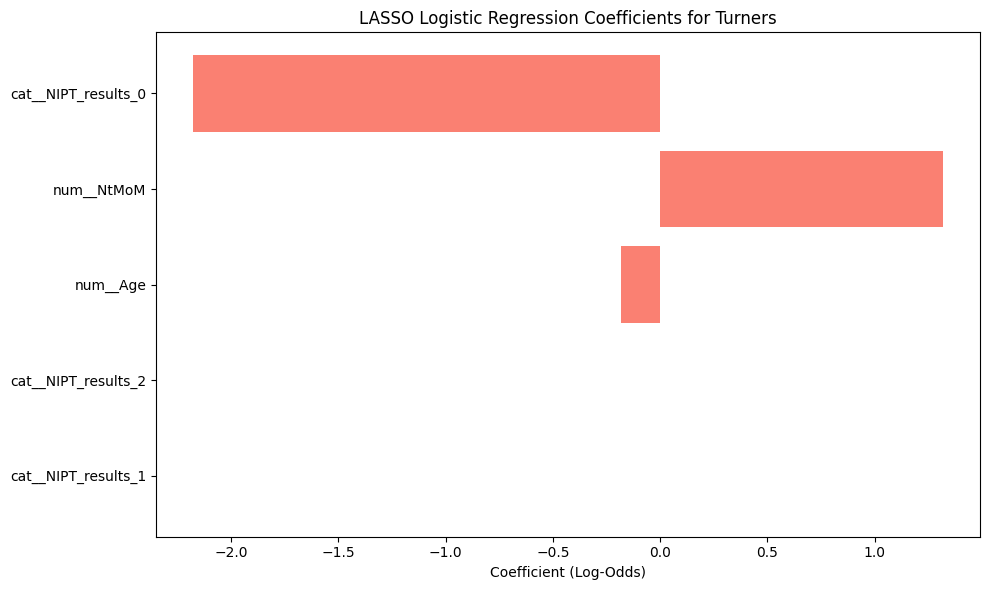

               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.182384
1           num__NtMoM     1.317013
2  cat__NIPT_results_0    -2.176414


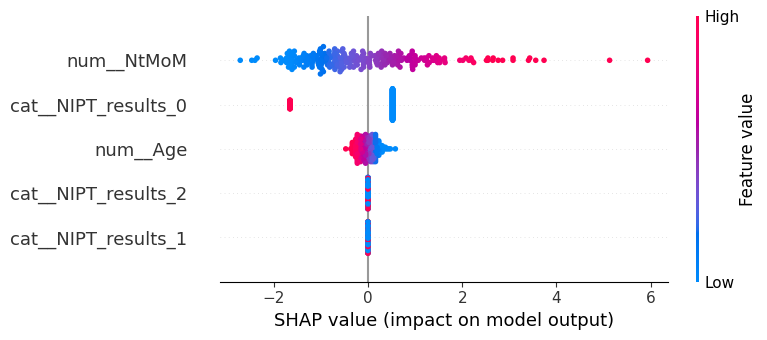


==== Coefficient and SHAP Analysis (LASSO) for OtherChroms ====


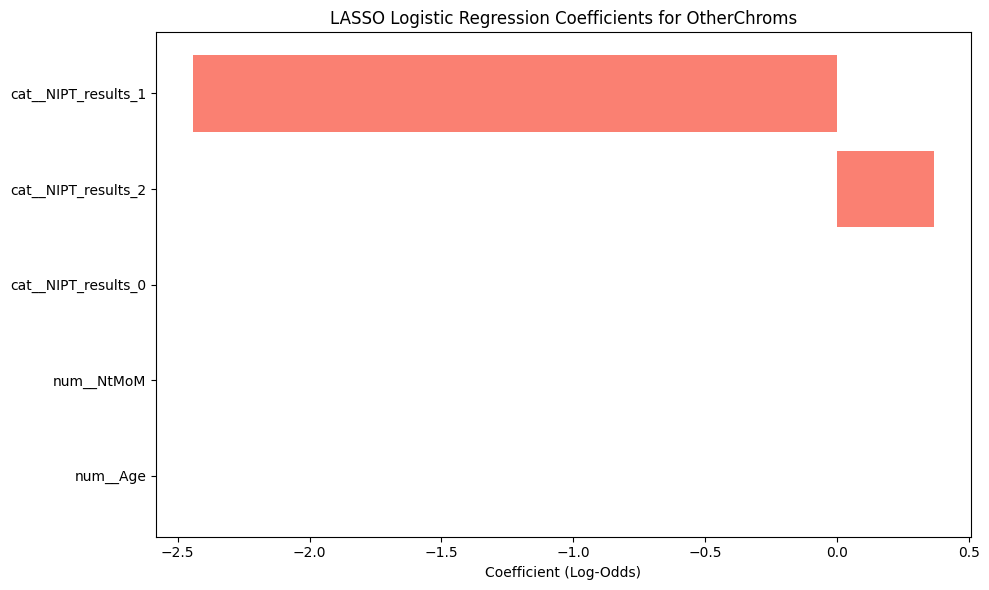

               Feature  Coefficient
0             num__Age     0.000000
1           num__NtMoM     0.000000
2  cat__NIPT_results_0     0.000000
4  cat__NIPT_results_2     0.367142
3  cat__NIPT_results_1    -2.441659


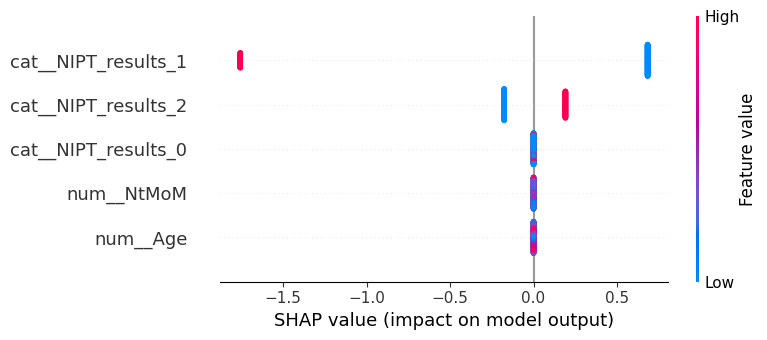

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import IterativeImputer

# Loop through each target and do coefficient + SHAP
for target in ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    print(f"\n==== Coefficient and SHAP Analysis (LASSO) for {target} ====")

    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)

    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l1',
            solver='saga',  # Required for L1 penalty
            max_iter=1000,
            C=1.0,
            random_state=42
        ))
    ])

    lasso_pipeline.fit(X, y)

    # Coefficients
    feature_names = preprocessor.get_feature_names_out()
    coefficients = lasso_pipeline.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='salmon')
    plt.xlabel('Coefficient (Log-Odds)')
    plt.title(f'LASSO Logistic Regression Coefficients for {target}')
    plt.tight_layout()
    plt.show()
    print(coef_df)

    # SHAP
    X_preprocessed = preprocessor.fit_transform(X)
    explainer = shap.LinearExplainer(lasso_pipeline.named_steps['classifier'], X_preprocessed, feature_names=feature_names)
    shap_values = explainer.shap_values(X_preprocessed)

    shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)


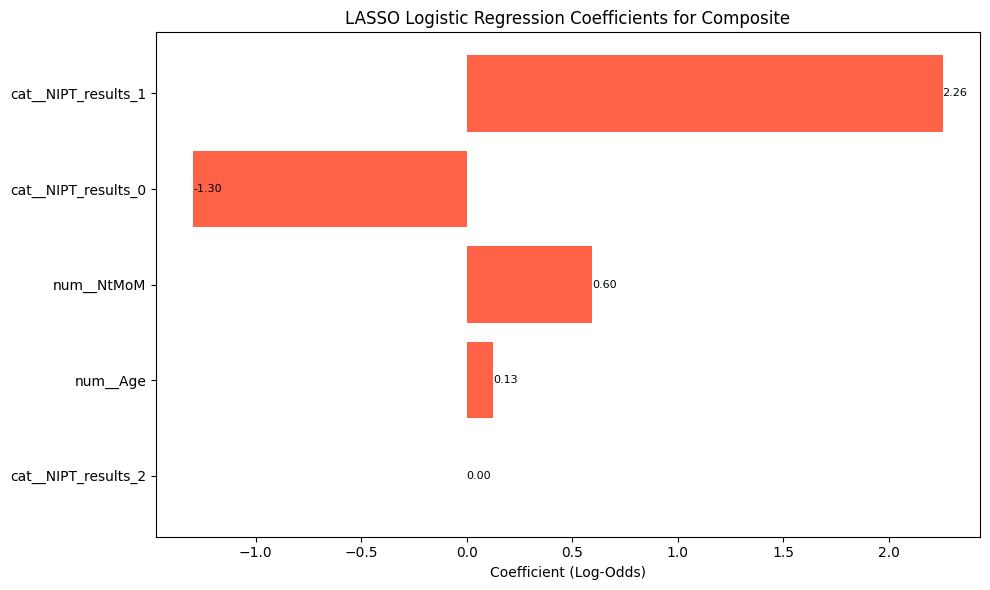

Saved: Composite_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.126658
1           num__NtMoM     0.595628
2  cat__NIPT_results_0    -1.295003
3  cat__NIPT_results_1     2.255351
Saved: Composite_shap_summary_lasso.png


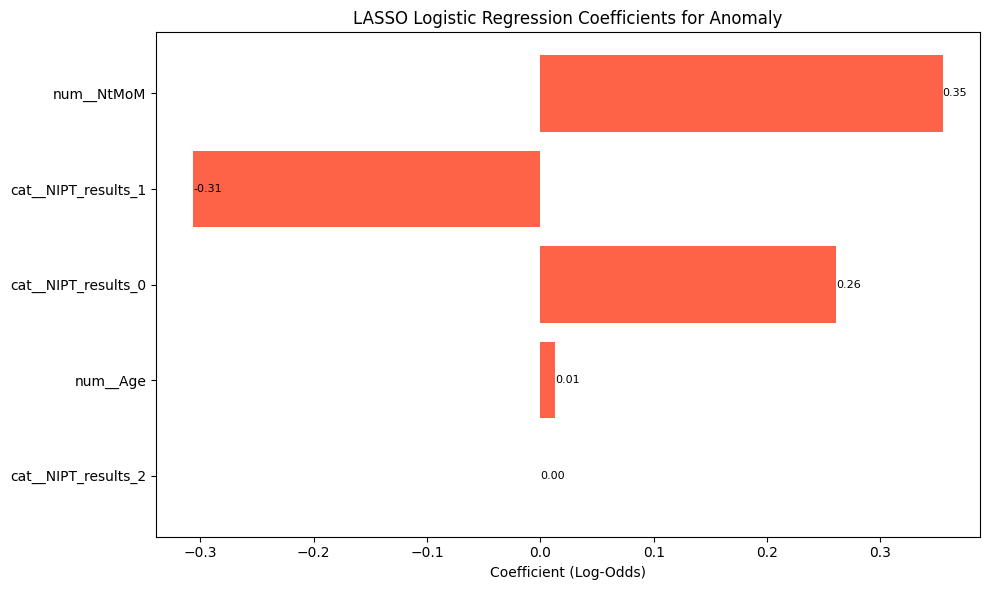

Saved: Anomaly_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.013073
2  cat__NIPT_results_0     0.261177
3  cat__NIPT_results_1    -0.306100
1           num__NtMoM     0.354760
Saved: Anomaly_shap_summary_lasso.png


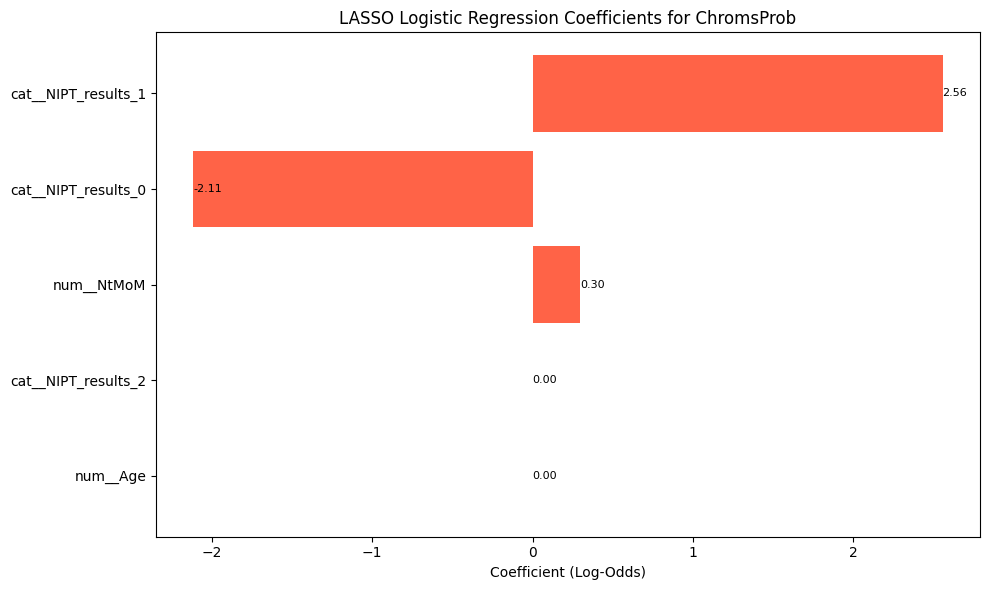

Saved: ChromsProb_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
4  cat__NIPT_results_2     0.000000
1           num__NtMoM     0.298326
2  cat__NIPT_results_0    -2.113538
3  cat__NIPT_results_1     2.555031
Saved: ChromsProb_shap_summary_lasso.png


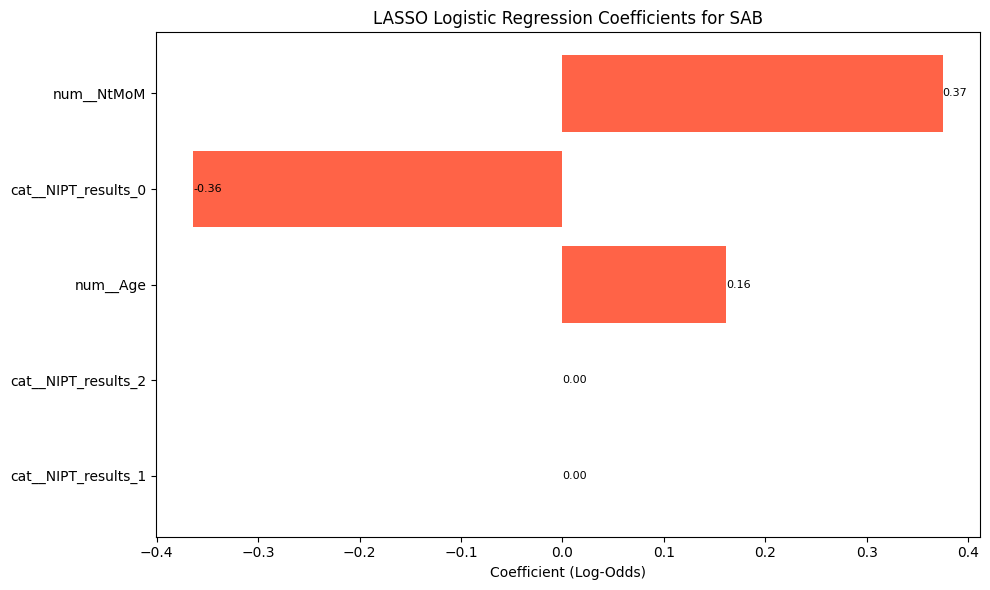

Saved: SAB_lasso_coefficients.png
               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age     0.161199
2  cat__NIPT_results_0    -0.363773
1           num__NtMoM     0.374793
Saved: SAB_shap_summary_lasso.png


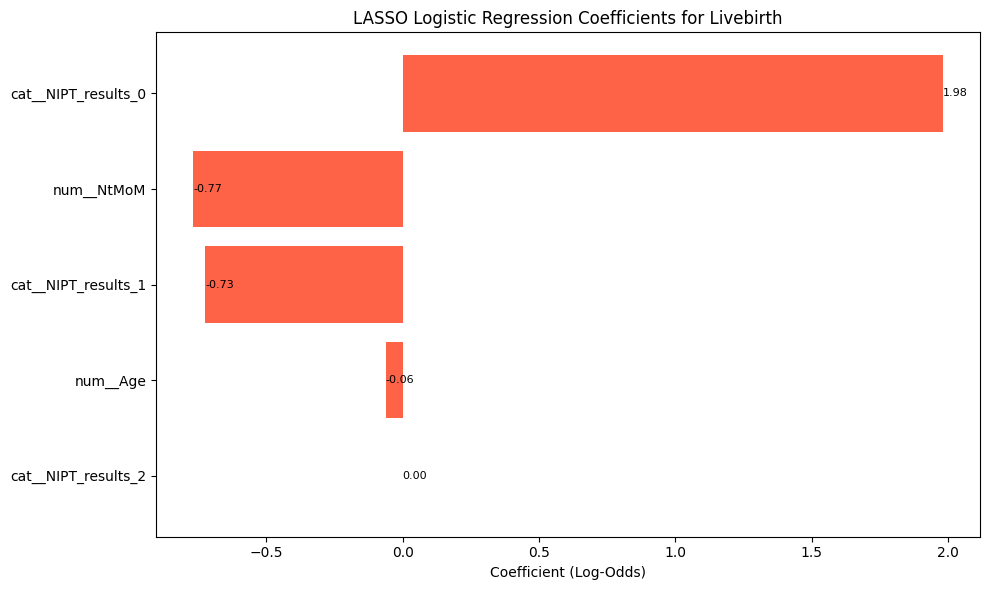

Saved: Livebirth_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.062487
3  cat__NIPT_results_1    -0.725343
1           num__NtMoM    -0.767927
2  cat__NIPT_results_0     1.980755
Saved: Livebirth_shap_summary_lasso.png


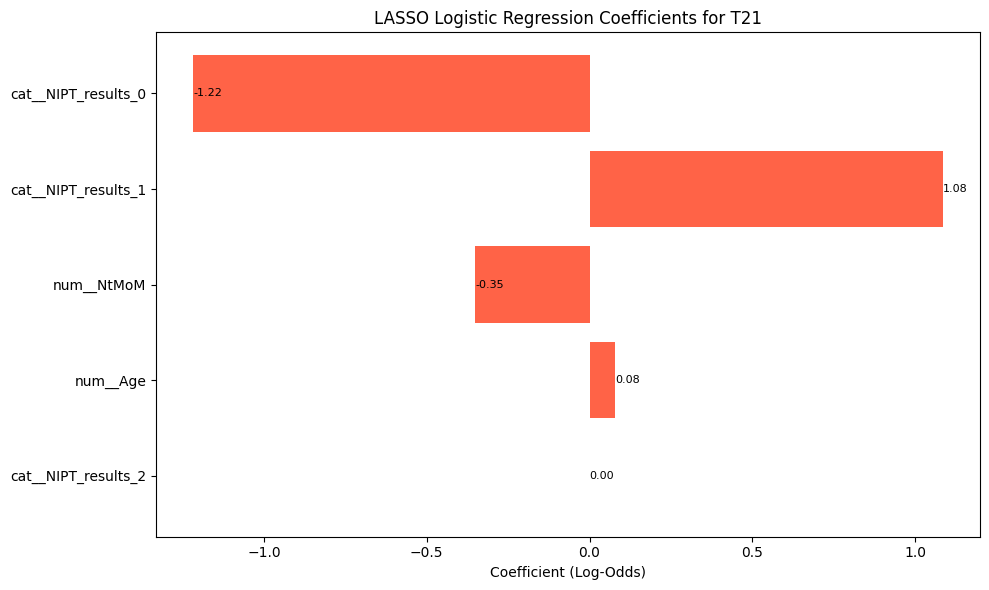

Saved: T21_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.078011
1           num__NtMoM    -0.351624
3  cat__NIPT_results_1     1.084048
2  cat__NIPT_results_0    -1.216568
Saved: T21_shap_summary_lasso.png


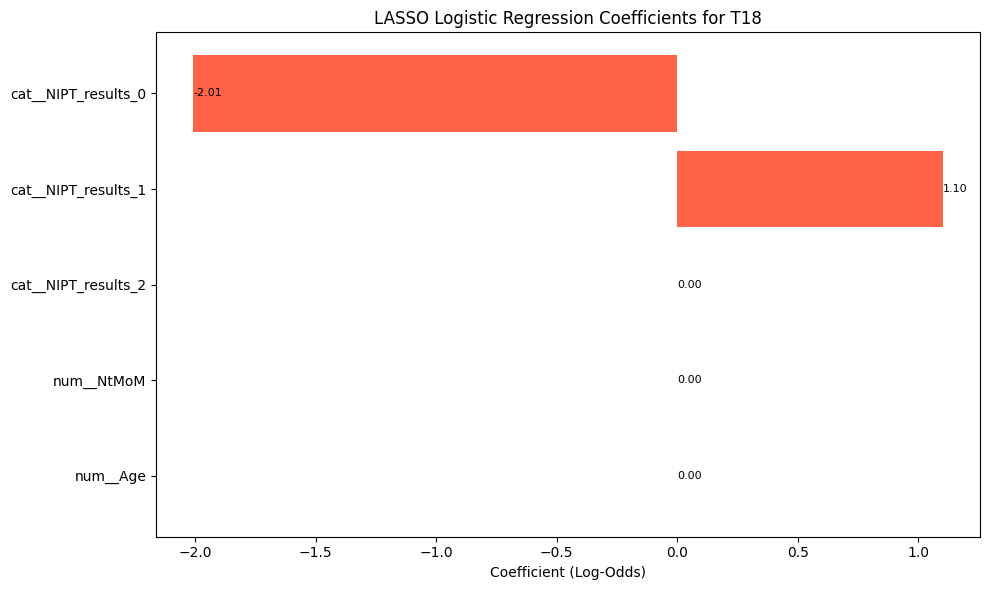

Saved: T18_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
1           num__NtMoM     0.000000
4  cat__NIPT_results_2     0.000000
3  cat__NIPT_results_1     1.101183
2  cat__NIPT_results_0    -2.006748
Saved: T18_shap_summary_lasso.png


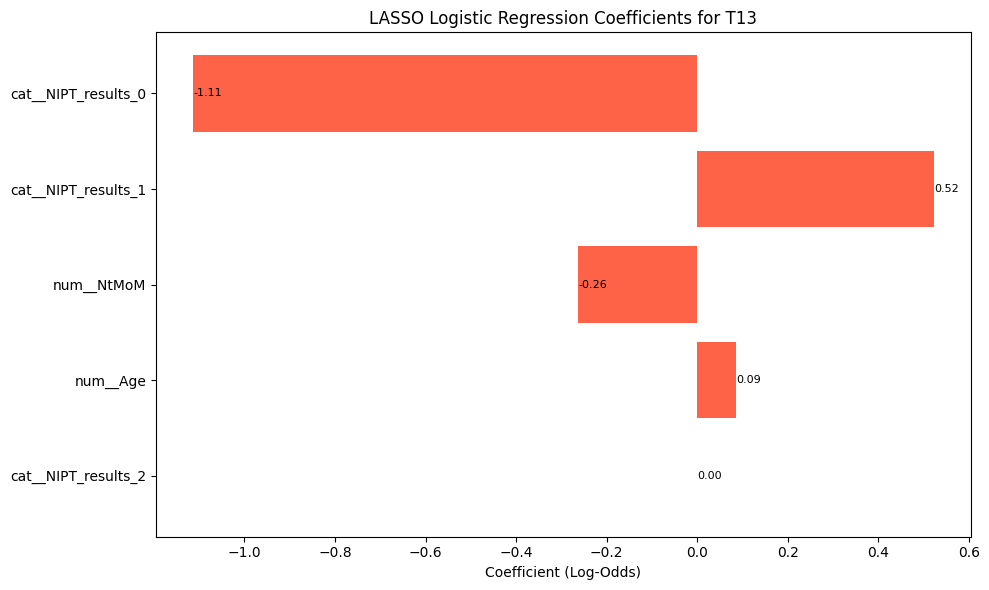

Saved: T13_lasso_coefficients.png
               Feature  Coefficient
4  cat__NIPT_results_2     0.000000
0             num__Age     0.085971
1           num__NtMoM    -0.262341
3  cat__NIPT_results_1     0.522712
2  cat__NIPT_results_0    -1.113505
Saved: T13_shap_summary_lasso.png


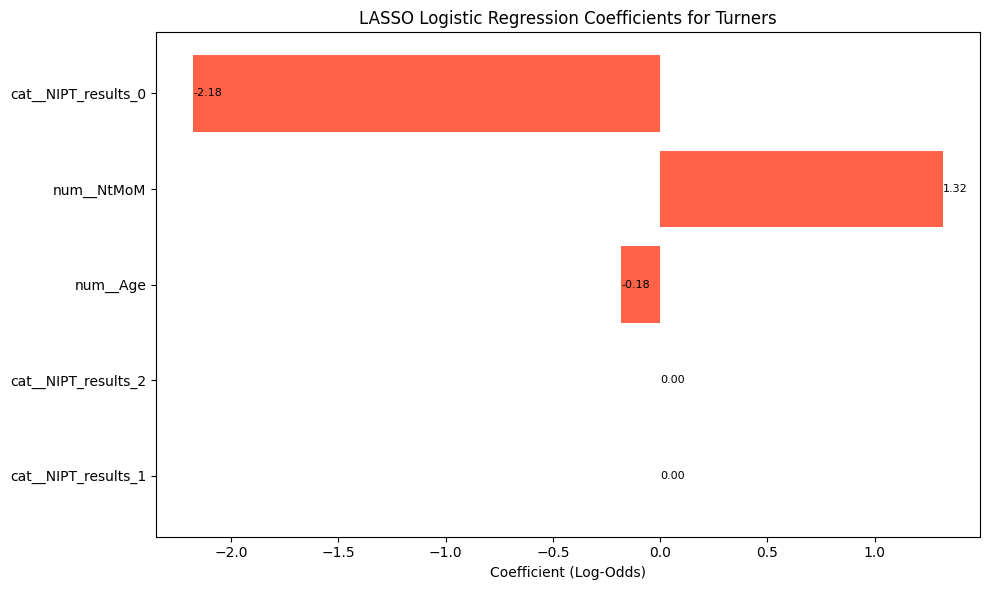

Saved: Turners_lasso_coefficients.png
               Feature  Coefficient
3  cat__NIPT_results_1     0.000000
4  cat__NIPT_results_2     0.000000
0             num__Age    -0.182384
1           num__NtMoM     1.317013
2  cat__NIPT_results_0    -2.176414
Saved: Turners_shap_summary_lasso.png


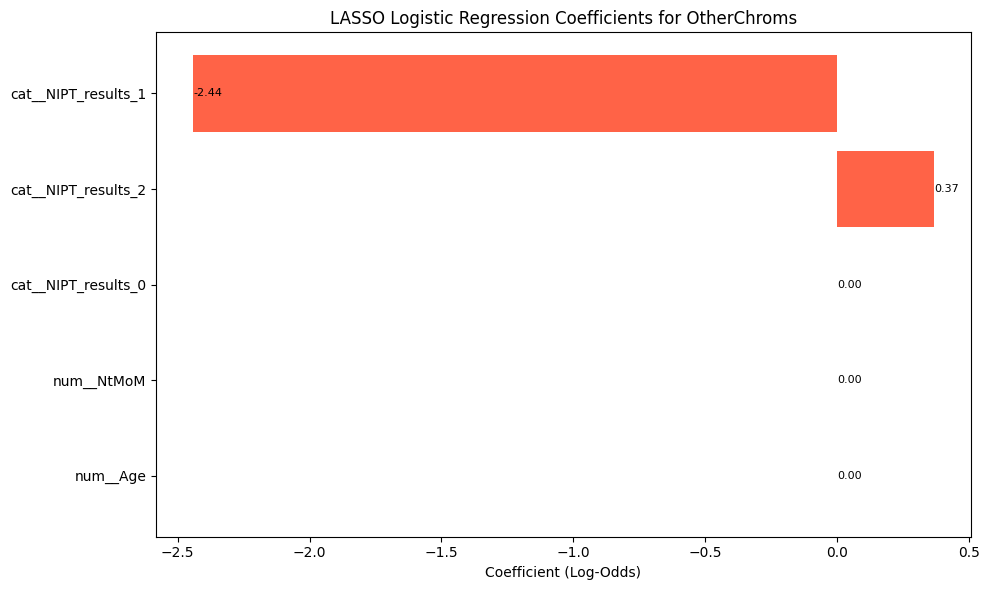

Saved: OtherChroms_lasso_coefficients.png
               Feature  Coefficient
0             num__Age     0.000000
1           num__NtMoM     0.000000
2  cat__NIPT_results_0     0.000000
4  cat__NIPT_results_2     0.367142
3  cat__NIPT_results_1    -2.441659
Saved: OtherChroms_shap_summary_lasso.png


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import IterativeImputer

for target in ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]:
    if target not in data.columns:
        print(f"{target} not found in data, skipping.")
        continue

    data_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    data_target[target] = pd.to_numeric(data_target[target], errors='coerce').astype(int)
    X = data_target[continuous_vars + categorical_vars].copy()
    y = data_target[target]

    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),
            ('scaler', StandardScaler())
        ]), continuous_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])

    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l1',
            solver='saga',  # Required for L1 penalty
            max_iter=1000,
            C=1.0,
            random_state=42
        ))
    ])

    lasso_pipeline.fit(X, y)
    feature_names = preprocessor.get_feature_names_out()
    coefficients = lasso_pipeline.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients}).sort_values(by='Coefficient', key=abs, ascending=True)

    # Coefficient bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='tomato')
    plt.xlabel('Coefficient (Log-Odds)')
    plt.title(f'LASSO Logistic Regression Coefficients for {target}')
    plt.tight_layout()

    # Add value labels to bars
    for bar, coef in zip(bars, coef_df['Coefficient']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{coef:.2f}',
                 va='center', ha='left', fontsize=8)

    plt.savefig(f"{target}_lasso_coefficients.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {target}_lasso_coefficients.png")
    print(coef_df)

    # SHAP summary plot
    X_preprocessed = preprocessor.fit_transform(X)
    explainer = shap.LinearExplainer(lasso_pipeline.named_steps['classifier'], X_preprocessed, feature_names=feature_names)
    shap_values = explainer.shap_values(X_preprocessed)

    shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, show=False)
    plt.savefig(f"{target}_shap_summary_lasso.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {target}_shap_summary_lasso.png")


In [14]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Define variables
continuous_vars = ['Age', 'NtMoM']
categorical_vars = ['NIPT_results']
target_vars = ['Composite', 'Anomaly', 'ChromsProb', 'SAB', 'Livebirth', "T21", "T18", "T13", "Turners", "OtherChroms"]

# Drop rows with missing or '.' in target variables
initial_rows = data.shape[0]
data = data[~data[target_vars].isnull().any(axis=1)]
data = data[~(data[target_vars] == ".").any(axis=1)]
print(f"\nDropped rows with missing or '.' in targets: {initial_rows - data.shape[0]}")

# Convert 'NIPT_results' to numeric, treat bad entries as 2
data['NIPT_results'] = pd.to_numeric(data['NIPT_results'], errors='coerce').fillna(2).astype(int)

# Convert continuous vars to numeric
for col in continuous_vars:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), continuous_vars),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_vars)
])

# Bootstrapping
n_bootstraps = 100

for target in target_vars:
    if target not in data.columns:
        print(f"{target} not found, skipping.")
        continue

    print(f"\nBootstrapping LASSO models for {target}...")
    models = []

    # Subset valid target data and drop rows with missing predictors
    df_target = data[pd.to_numeric(data[target], errors='coerce').notna()].copy()
    df_target[target] = pd.to_numeric(df_target[target], errors='coerce').astype(int)
    df_target = df_target.dropna(subset=continuous_vars + categorical_vars)

    for i in range(n_bootstraps):
        boot_data = resample(df_target, replace=True, random_state=i)
        X = boot_data[continuous_vars + categorical_vars]
        y = boot_data[target]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                penalty='l1',
                solver='saga',
                max_iter=1000,
                C=1.0,
                random_state=42
            ))
        ])

        pipeline.fit(X, y)
        models.append(pipeline)

    with open(f'bootstrapped_lasso_models_{target}.pkl', 'wb') as f:
        pickle.dump(models, f)

    print(f"‚úÖ Saved bootstrapped LASSO models for {target}")

print("\nüéâ All bootstrapped LASSO models saved.")



Dropped rows with missing or '.' in targets: 0

Bootstrapping LASSO models for Composite...
‚úÖ Saved bootstrapped LASSO models for Composite

Bootstrapping LASSO models for Anomaly...
‚úÖ Saved bootstrapped LASSO models for Anomaly

Bootstrapping LASSO models for ChromsProb...
‚úÖ Saved bootstrapped LASSO models for ChromsProb

Bootstrapping LASSO models for SAB...
‚úÖ Saved bootstrapped LASSO models for SAB

Bootstrapping LASSO models for Livebirth...
‚úÖ Saved bootstrapped LASSO models for Livebirth

Bootstrapping LASSO models for T21...
‚úÖ Saved bootstrapped LASSO models for T21

Bootstrapping LASSO models for T18...
‚úÖ Saved bootstrapped LASSO models for T18

Bootstrapping LASSO models for T13...
‚úÖ Saved bootstrapped LASSO models for T13

Bootstrapping LASSO models for Turners...
‚úÖ Saved bootstrapped LASSO models for Turners

Bootstrapping LASSO models for OtherChroms...
‚úÖ Saved bootstrapped LASSO models for OtherChroms

üéâ All bootstrapped LASSO models saved.


In [19]:
# ------------------- CH-FILTERED SETUP -------------------
outcomes_CH = ['Anomaly', 'SAB', 'Livebirth', 'OtherChroms']
continuous_vars_CH = ['NtMoM']
categorical_vars_CH = ['ResolvedCH']

# ------------------- FILTER & CLEAN CH-FOCUSED DATA -------------------
data_filtered_CH = data.copy()

# Keep only rows where T21, T18, T13, Turners == 0
data_filtered_CH = data_filtered_CH[
    (data_filtered_CH[['T21', 'T18', 'T13', 'Turners']] == 0).all(axis=1)
]

# Coerce ResolvedCH to numeric and assign unknowns to 2
data_filtered_CH['ResolvedCH'] = pd.to_numeric(data_filtered_CH['ResolvedCH'], errors='coerce').fillna(2).astype(int)

# Drop rows with missing predictor variables
data_filtered_CH = data_filtered_CH.dropna(subset=continuous_vars_CH)

print(f"Filtered CH data size (including unknown ResolvedCH as 2): {data_filtered_CH.shape}")

Filtered CH data size (including unknown ResolvedCH as 2): (106, 14)


In [20]:
# ------------------- CHECK DISTINCT VALUES -------------------
print("\nDistinct values in 'ResolvedCH' after cleaning:")
print(data_filtered_CH['ResolvedCH'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'ResolvedCH':")
print(data_filtered_CH['ResolvedCH'].unique())


Distinct values in 'ResolvedCH' after cleaning:
ResolvedCH
0    41
1    24
2    41
Name: count, dtype: int64

Unique values in 'ResolvedCH':
[0 2 1]


In [30]:
# Drop rows with missing predictor variables
data_filtered_CH = data_filtered_CH.dropna(subset=continuous_vars_CH)

# Keep only known ResolvedCH values (0 or 1)
data_filtered_CH = data_filtered_CH[data_filtered_CH['ResolvedCH'].isin([0, 1])]

print(f"Filtered CH data size with ResolvedCH = 0 or 1 only: {data_filtered_CH.shape}")

print("\nUnique values in 'ResolvedCH':")
print(data_filtered_CH['ResolvedCH'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Anomaly':")
print(data_filtered_CH['Anomaly'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'SAB':")
print(data_filtered_CH['SAB'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'Livebirth':")
print(data_filtered_CH['Livebirth'].value_counts(dropna=False).sort_index())

print("\nUnique values in 'OtherChroms':")
print(data_filtered_CH['OtherChroms'].value_counts(dropna=False).sort_index())

Filtered CH data size with ResolvedCH = 0 or 1 only: (65, 14)

Unique values in 'ResolvedCH':
ResolvedCH
0    41
1    24
Name: count, dtype: int64

Unique values in 'Anomaly':
Anomaly
0    44
1    21
Name: count, dtype: int64

Unique values in 'SAB':
SAB
0    62
1     3
Name: count, dtype: int64

Unique values in 'Livebirth':
Livebirth
0    13
1    52
Name: count, dtype: int64

Unique values in 'OtherChroms':
OtherChroms
0.0    53
1.0    12
Name: count, dtype: int64


In [22]:
# ------------------- DEFINE MODELS -------------------
models_CH = {
    'Lasso_Logistic_Regression': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=1.0, random_state=42),
    'Ridge_Logistic_Regression': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=1.0, random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'Naive_Bayes': BernoulliNB(),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=300, random_state=42)
}

# ------------------- PREPROCESSOR -------------------
preprocessor_CH = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), continuous_vars_CH),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_vars_CH)
])

In [26]:
# ------------------- DEFINE METRICS -------------------
scorers_CH = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

# ------------------- EVALUATE & SELECT BEST MODEL -------------------
best_models_CH = {}

for outcome in outcomes_CH:
    print(f"\n==== Evaluating for target: {outcome} ====")
    df_target_CH = data_filtered_CH.copy()
    df_target_CH[outcome] = pd.to_numeric(df_target_CH[outcome], errors='coerce')
    df_target_CH = df_target_CH.dropna(subset=[outcome])
    X_CH = df_target_CH[continuous_vars_CH + categorical_vars_CH]
    y_CH = df_target_CH[outcome].astype(int)

    results_dict = {}
    best_score = -np.inf
    best_model_name = None

    for name, model in models_CH.items():
        pipeline_CH = ImbPipeline([
            ('preprocessor', preprocessor_CH),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        try:
            cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = cross_validate(pipeline_CH, X_CH, y_CH, scoring=scorers_CH, cv=cv_strategy, n_jobs=-1)

            avg_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scorers_CH}
            results_dict[name] = avg_scores

            if avg_scores['roc_auc'] > best_score:
                best_score = avg_scores['roc_auc']
                best_model_name = name
        except Exception as e:
            print(f"{name} failed: {e}")

    # Print metrics like the screenshot
    metrics_df = pd.DataFrame(results_dict).T
    print(f"\nResults for {outcome}:\n")
    print(metrics_df.round(6))

    best_models_CH[outcome] = best_model_name
    print(f"\n‚úÖ Best CH model for {outcome}: {best_model_name} (ROC AUC = {best_score:.4f})\n")



==== Evaluating for target: Anomaly ====


/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim


Results for Anomaly:

                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.658730   0.529762  0.857143  0.634231  0.418488   
Ridge_Logistic_Regression  0.658730   0.529762  0.857143  0.634231  0.418488   
Random_Forest              0.599567   0.384259  0.428571  0.402564  0.104938   
SVM_RBF                    0.628427   0.513889  0.714286  0.529469  0.323937   
SVM_Linear                 0.643579   0.500000  0.857143  0.618357  0.390822   
XGBoost                    0.598846   0.412879  0.523810  0.459259  0.151573   
Naive_Bayes                0.628427   0.473485  0.904762  0.618357  0.387487   
KNN                        0.644300   0.494872  0.666667  0.543860  0.298144   
MLP                        0.613276   0.480556  0.761905  0.552701  0.317640   

                            roc_auc  
Lasso_Logistic_Regression  0.717007  
Ridge_Logistic_Regression  0.743991  
Random_Forest              0.698866  
SVM_RBF                 

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim


Results for Livebirth:

                           accuracy  precision    recall        f1       mcc  \
Lasso_Logistic_Regression  0.647908   0.948413  0.595861  0.718459  0.359647   
Ridge_Logistic_Regression  0.663059   0.950549  0.614379  0.732079  0.375362   
Random_Forest              0.631313   0.807787  0.713508  0.754087  0.021809   
SVM_RBF                    0.616883   0.886111  0.595861  0.701944  0.231429   
SVM_Linear                 0.616883   0.925253  0.577342  0.695163  0.278757   
XGBoost                    0.616162   0.847680  0.635076  0.724731  0.147062   
Naive_Bayes                0.586580   0.955556  0.521786  0.651944  0.307533   
KNN                        0.662338   0.910873  0.655773  0.751308  0.268102   
MLP                        0.632035   0.890741  0.615468  0.720406  0.246813   

                            roc_auc  
Lasso_Logistic_Regression  0.740741  
Ridge_Logistic_Regression  0.670153  
Random_Forest              0.712500  
SVM_RBF               

/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

In [31]:
# ------------------- BOOTSTRAP & SAVE MODELS FOR STREAMLIT -------------------
from sklearn.base import clone

boot_model_map = {
    'Anomaly': MLPClassifier(max_iter=300, random_state=42),
    'Livebirth': BernoulliNB(),
    'OtherChroms': SVC(kernel='rbf', probability=True, random_state=42)
}

n_bootstraps = 100

for outcome in ['Anomaly', 'Livebirth', 'OtherChroms']:
    print(f"\nüì¶ Bootstrapping {outcome} using {best_models_CH[outcome]}...")

    df_target_CH = data_filtered_CH.copy()
    df_target_CH[outcome] = pd.to_numeric(df_target_CH[outcome], errors='coerce')
    df_target_CH = df_target_CH.dropna(subset=[outcome])
    X_CH = df_target_CH[continuous_vars_CH + categorical_vars_CH]
    y_CH = df_target_CH[outcome].astype(int)

    models_boot = []

    for i in range(n_bootstraps):
        boot_df = resample(df_target_CH, replace=True, random_state=i)
        X_boot = boot_df[continuous_vars_CH + categorical_vars_CH]
        y_boot = boot_df[outcome].astype(int)

        # Define pipeline for current bootstrap
        pipeline = Pipeline([
            ('preprocessor', preprocessor_CH),
            ('classifier', clone(boot_model_map[outcome]))  # clone ensures fresh model each time
        ])

        try:
            pipeline.fit(X_boot, y_boot)
            models_boot.append(pipeline)
        except Exception as e:
            print(f"‚ö†Ô∏è  Bootstrap {i} failed for {outcome}: {e}")

    with open(f'bootstrapped_{best_models_CH[outcome]}_models_{outcome}.pkl', 'wb') as f:
        pickle.dump(models_boot, f)

    print(f"‚úÖ Saved: bootstrapped_{best_models_CH[outcome]}_models_{outcome}.pkl")



üì¶ Bootstrapping Anomaly using MLP...


/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/pregnancy_risk_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't conv

‚úÖ Saved: bootstrapped_MLP_models_Anomaly.pkl

üì¶ Bootstrapping Livebirth using Naive_Bayes...
‚úÖ Saved: bootstrapped_Naive_Bayes_models_Livebirth.pkl

üì¶ Bootstrapping OtherChroms using SVM_RBF...
‚úÖ Saved: bootstrapped_SVM_RBF_models_OtherChroms.pkl
